In [1]:
import numpy as np
import pandas as pd
import pathlib as pl
import matplotlib as mpl

mpl.use("Cairo")  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

import candas as can
from candas.test import QuantStudio
from candas.lims import Librarian, library

from tinydb import TinyDB

lib = Librarian().load(library).open()

In [2]:
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

plt.style.use(can.style.breve)

%config InlineBackend.figure_format = 'retina'

from utils import savefig

plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["lines.linewidth"] = 1

In [3]:
db_file = data_pth / "JG071A Reaction Specifications.json"
rxn_db = TinyDB(db_file)
JG071A_rxns = pd.DataFrame(
    [rxn["oligos"] | {"Sample": rxn["name"]} for rxn in rxn_db.all()]
)

cmax = 50

file = data_pth / "JG071A ARG1 Tripartite.xlsx"
JG071A = (
    QuantStudio(file, "JG071A")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .drop(lambda df: df["Well"].isin([281]))
    .normalize_reactions(cmax=cmax, method="max")
    .invert_fluorophore("HEX")
)

JG071A.reactions.data = JG071A.reactions.data.merge(JG071A_rxns)
for oligo in ["S036.0", "S057.0.1", "S057.1.2"]:
    JG071A.reactions.data["log$_{1}$$_{0}$ " + oligo] = np.log10(
        JG071A.reactions.data[oligo]
    )

JG071A.extract_endpoints(cmax=cmax, name="FAM-HEX", method="diff")

In [4]:
width = 3.45
height = 2.75 + 0.2
figsize = (width, height)
spotsize = 4**2
ticklabelsize = 5
labelsize = 6
linewidth = 1

palette = sns.diverging_palette(20, 220, as_cmap=True)

mar_l = 0.3
mar_r = 0.3
mar_t = 0.22
mar_b = 0.275 + 0.2
ax_space = 0.075


def format_sns_axes(g, xticks, xlim, ylim=None):
    fig = g.figure
    fig.set_size_inches(figsize)

    # g.set_titles('')

    ylim = ylim or [-1.1, 1.1]

    plt.setp(
        g.axes,
        ylim=ylim,
        yticks=[-1, -0.5, 0, 0.5, 1],
        xticks=xticks,
        xlim=xlim,
        title="",
    )
    for i, ax in enumerate(g.axes.flat):
        ax.tick_params(axis="both", labelsize=ticklabelsize, length=1, width=0.6)
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=0)
        ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)
        # if i > 0:
        #     ax.yaxis.set_tick_params(length=0)
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

    for (row, col), ax in g.axes_dict.items():
        ax.set_title("")

        if col == 8.0:
            ax2 = ax.twinx()
            ax2.set_yticks([])
            ax2.set_ylabel(
                f"{row:.1f}", va="bottom", fontsize=labelsize, rotation=270, labelpad=1
            )
            if row == 5.0:
                ax2.set_ylabel(
                    f"log$_{1}$$_{0}$ Copies Competitor 2\n{row:.1f}",
                    va="bottom",
                    fontsize=labelsize,
                    rotation=270,
                    labelpad=1,
                )

        if row == 8.0:
            ax.set_title(f"{col:.1f}", fontsize=labelsize, pad=2)
            if col == 5.0:
                ax.set_title(
                    f"log$_{1}$$_{0}$ Copies Competitor 1\n{col:.1f}",
                    fontsize=labelsize,
                    pad=2,
                )

        if ax != g.axes[-1, 0]:
            ax.set_xlabel("")
            ax.set_ylabel("")

    bbox = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
    ax_width, ax_height = bbox.width, bbox.height

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        wspace=ax_space / ax_width,
        hspace=ax_space / ax_height,
    )

Saving fig_S4A__distant_rhea in /home/john/projects/can-manuscript/fig_S4__rapid_quetzal/graphics: [.svg] [.png] done


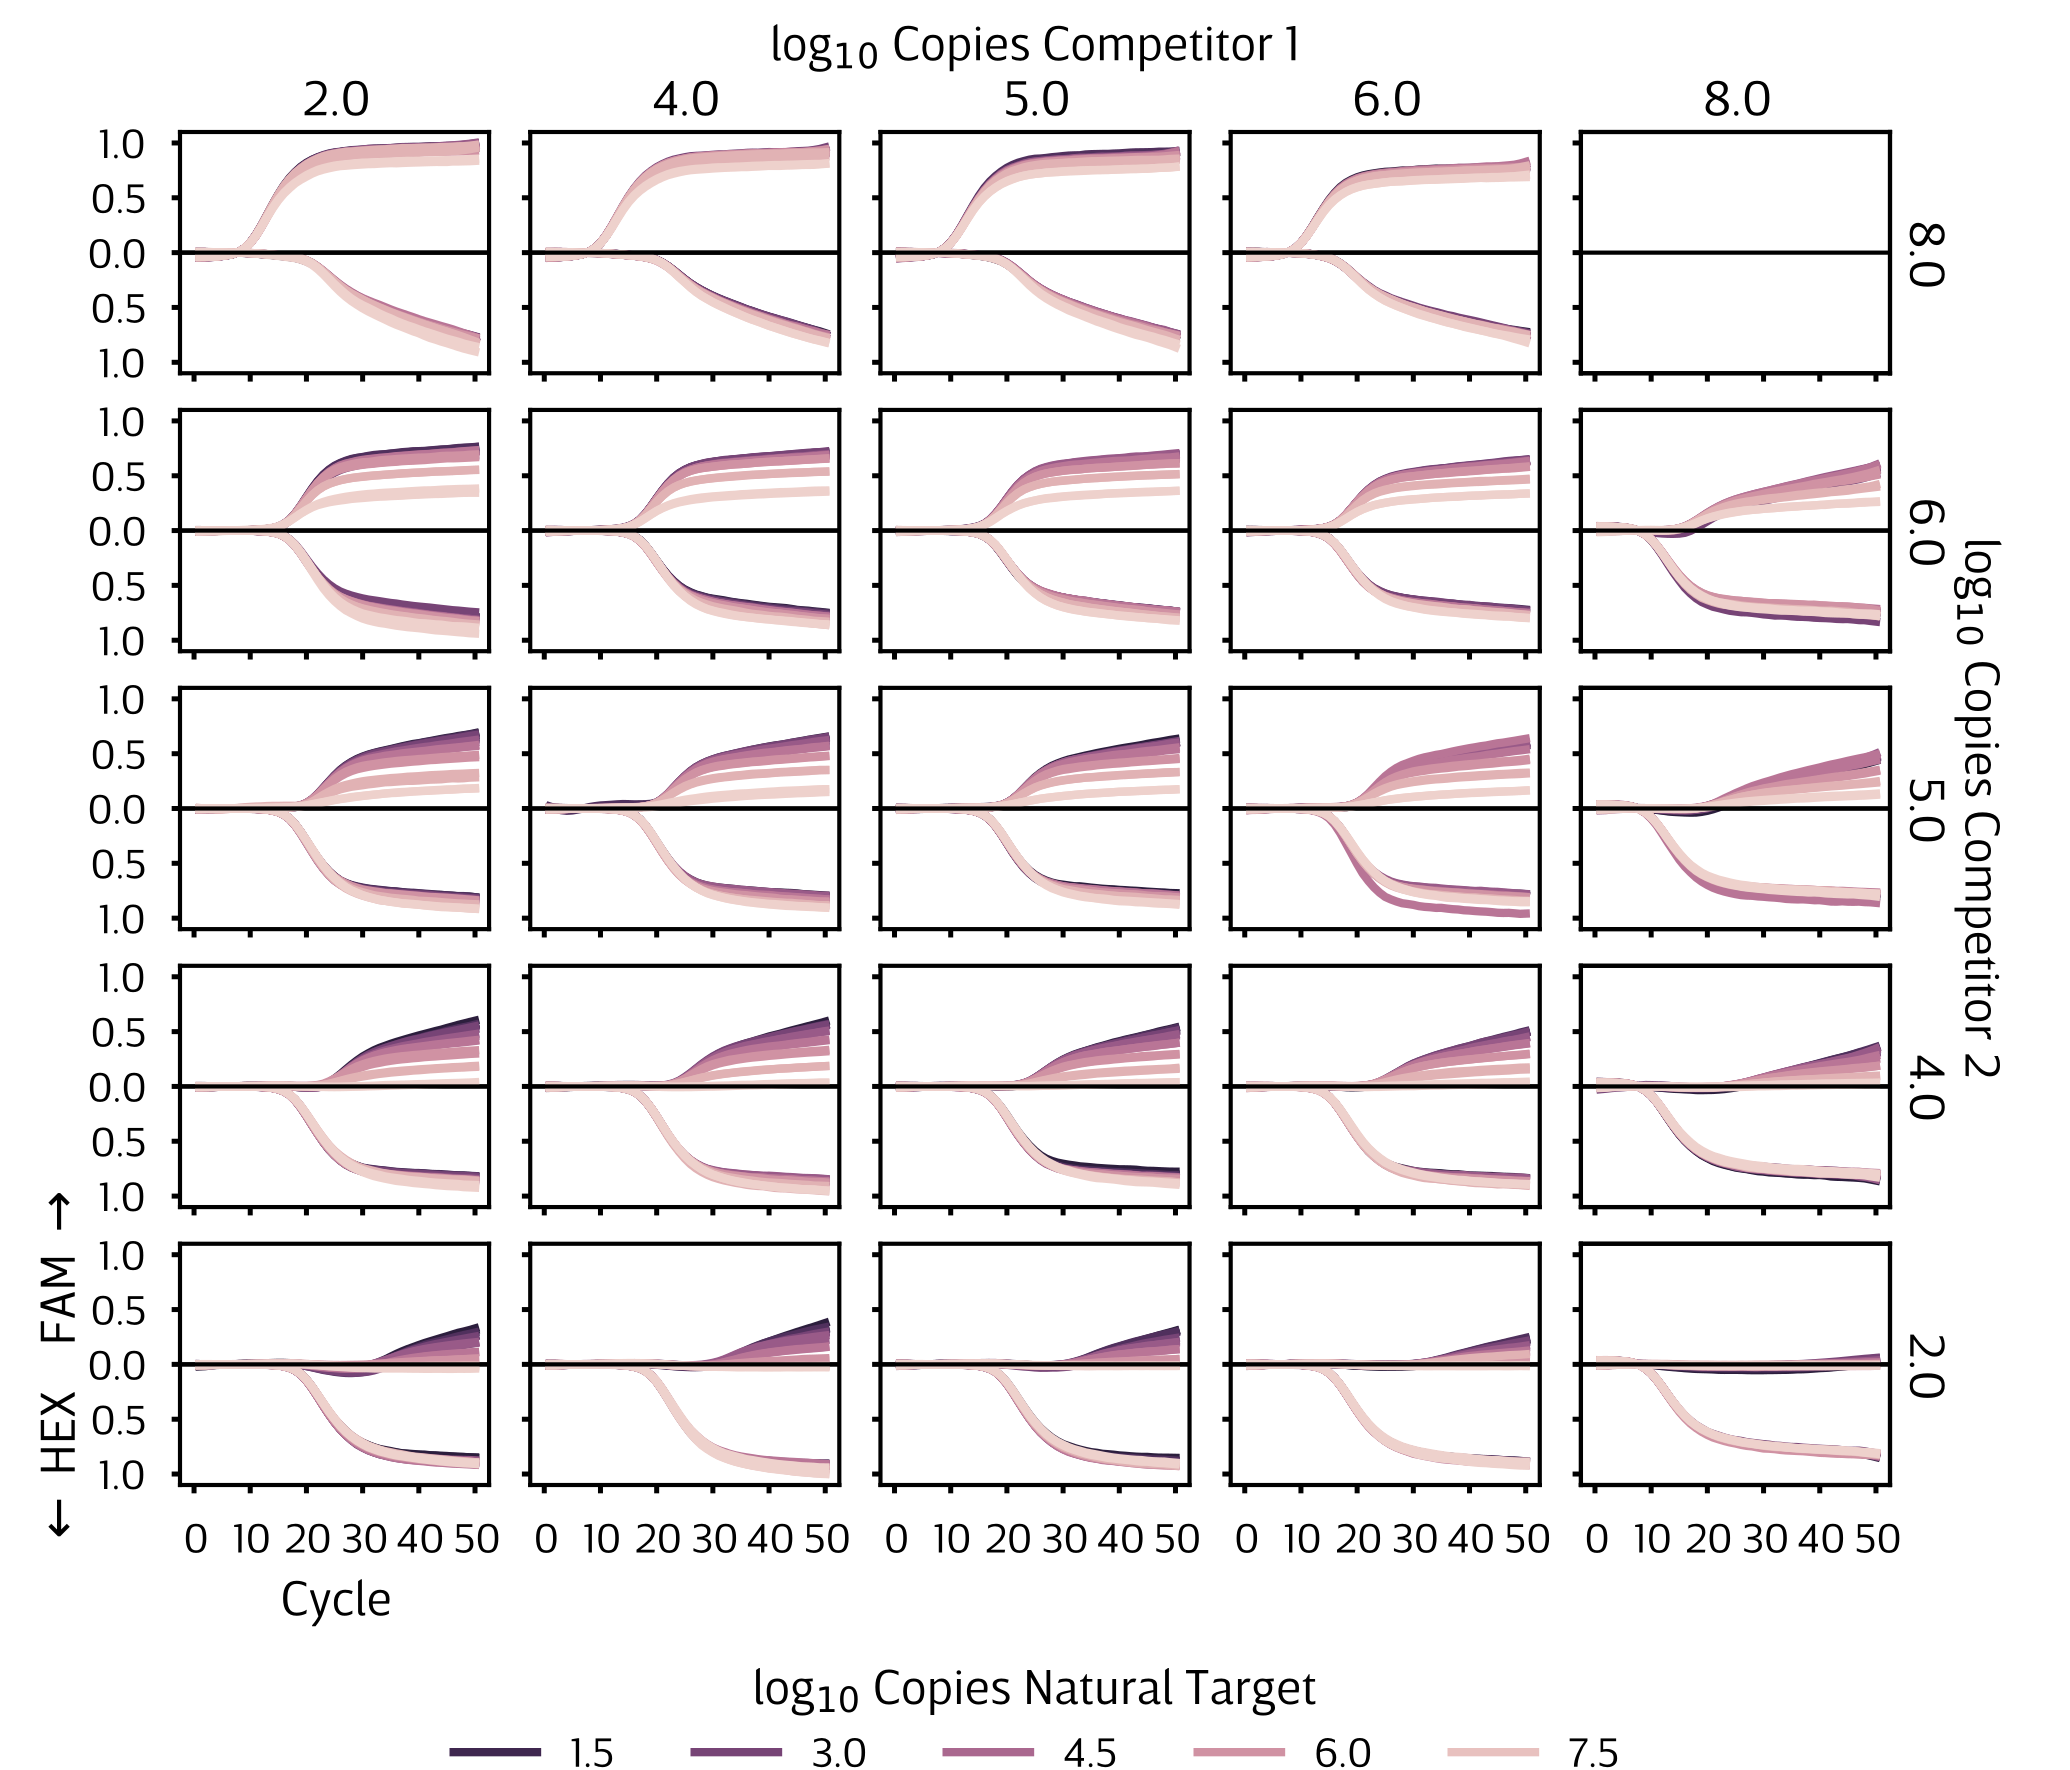

In [5]:
hue = "log$_{1}$$_{0}$ S036.0"
extent = np.max(np.abs(JG071A.reactions.wide[hue]))
norm = mpl.colors.Normalize(
    vmin=JG071A.reactions.wide[hue].min(), vmax=JG071A.reactions.wide[hue].max()
)

g = sns.relplot(
    data=JG071A.reactions.data.query("Cycle<=@cmax"),
    x="Cycle",
    y="Fluorescence",
    col="log$_{1}$$_{0}$ S057.0.1",
    row="log$_{1}$$_{0}$ S057.1.2",
    units="Reaction",
    hue=hue,
    # legend=False,
    palette="ch:0_r",
    hue_norm=norm,
    kind="line",
    estimator=None,
    linewidth=linewidth,
    row_order=JG071A.reactions.data["log$_{1}$$_{0}$ S057.1.2"].unique()[::-1],
    facet_kws={"margin_titles": False, "despine": False},
)

sns.move_legend(
    g,
    "lower center",
    bbox_to_anchor=(0.5, -0.025),
    title=r"log$_{10}$ Copies Natural Target",
    title_fontsize=labelsize,
    fontsize=ticklabelsize,
    ncol=5,
    frameon=False,
)


g.set_ylabels(r"$\leftarrow$ HEX    FAM $\rightarrow$")
g.refline(y=0, color="k", linestyle="-", linewidth=0.5)
format_sns_axes(g, xticks=[0, 10, 20, 30, 40, 50], xlim=[-2.5, 52.5])

g.set_yticklabels([1.0, 0.5, 0.0, 0.5, 1.0])

savefig(plt.gcf(), alias="distant_rhea")

Saving fig_S4B__crimson_stingray in /home/john/projects/can-manuscript/fig_S4__rapid_quetzal/graphics: [.svg] [.png] done


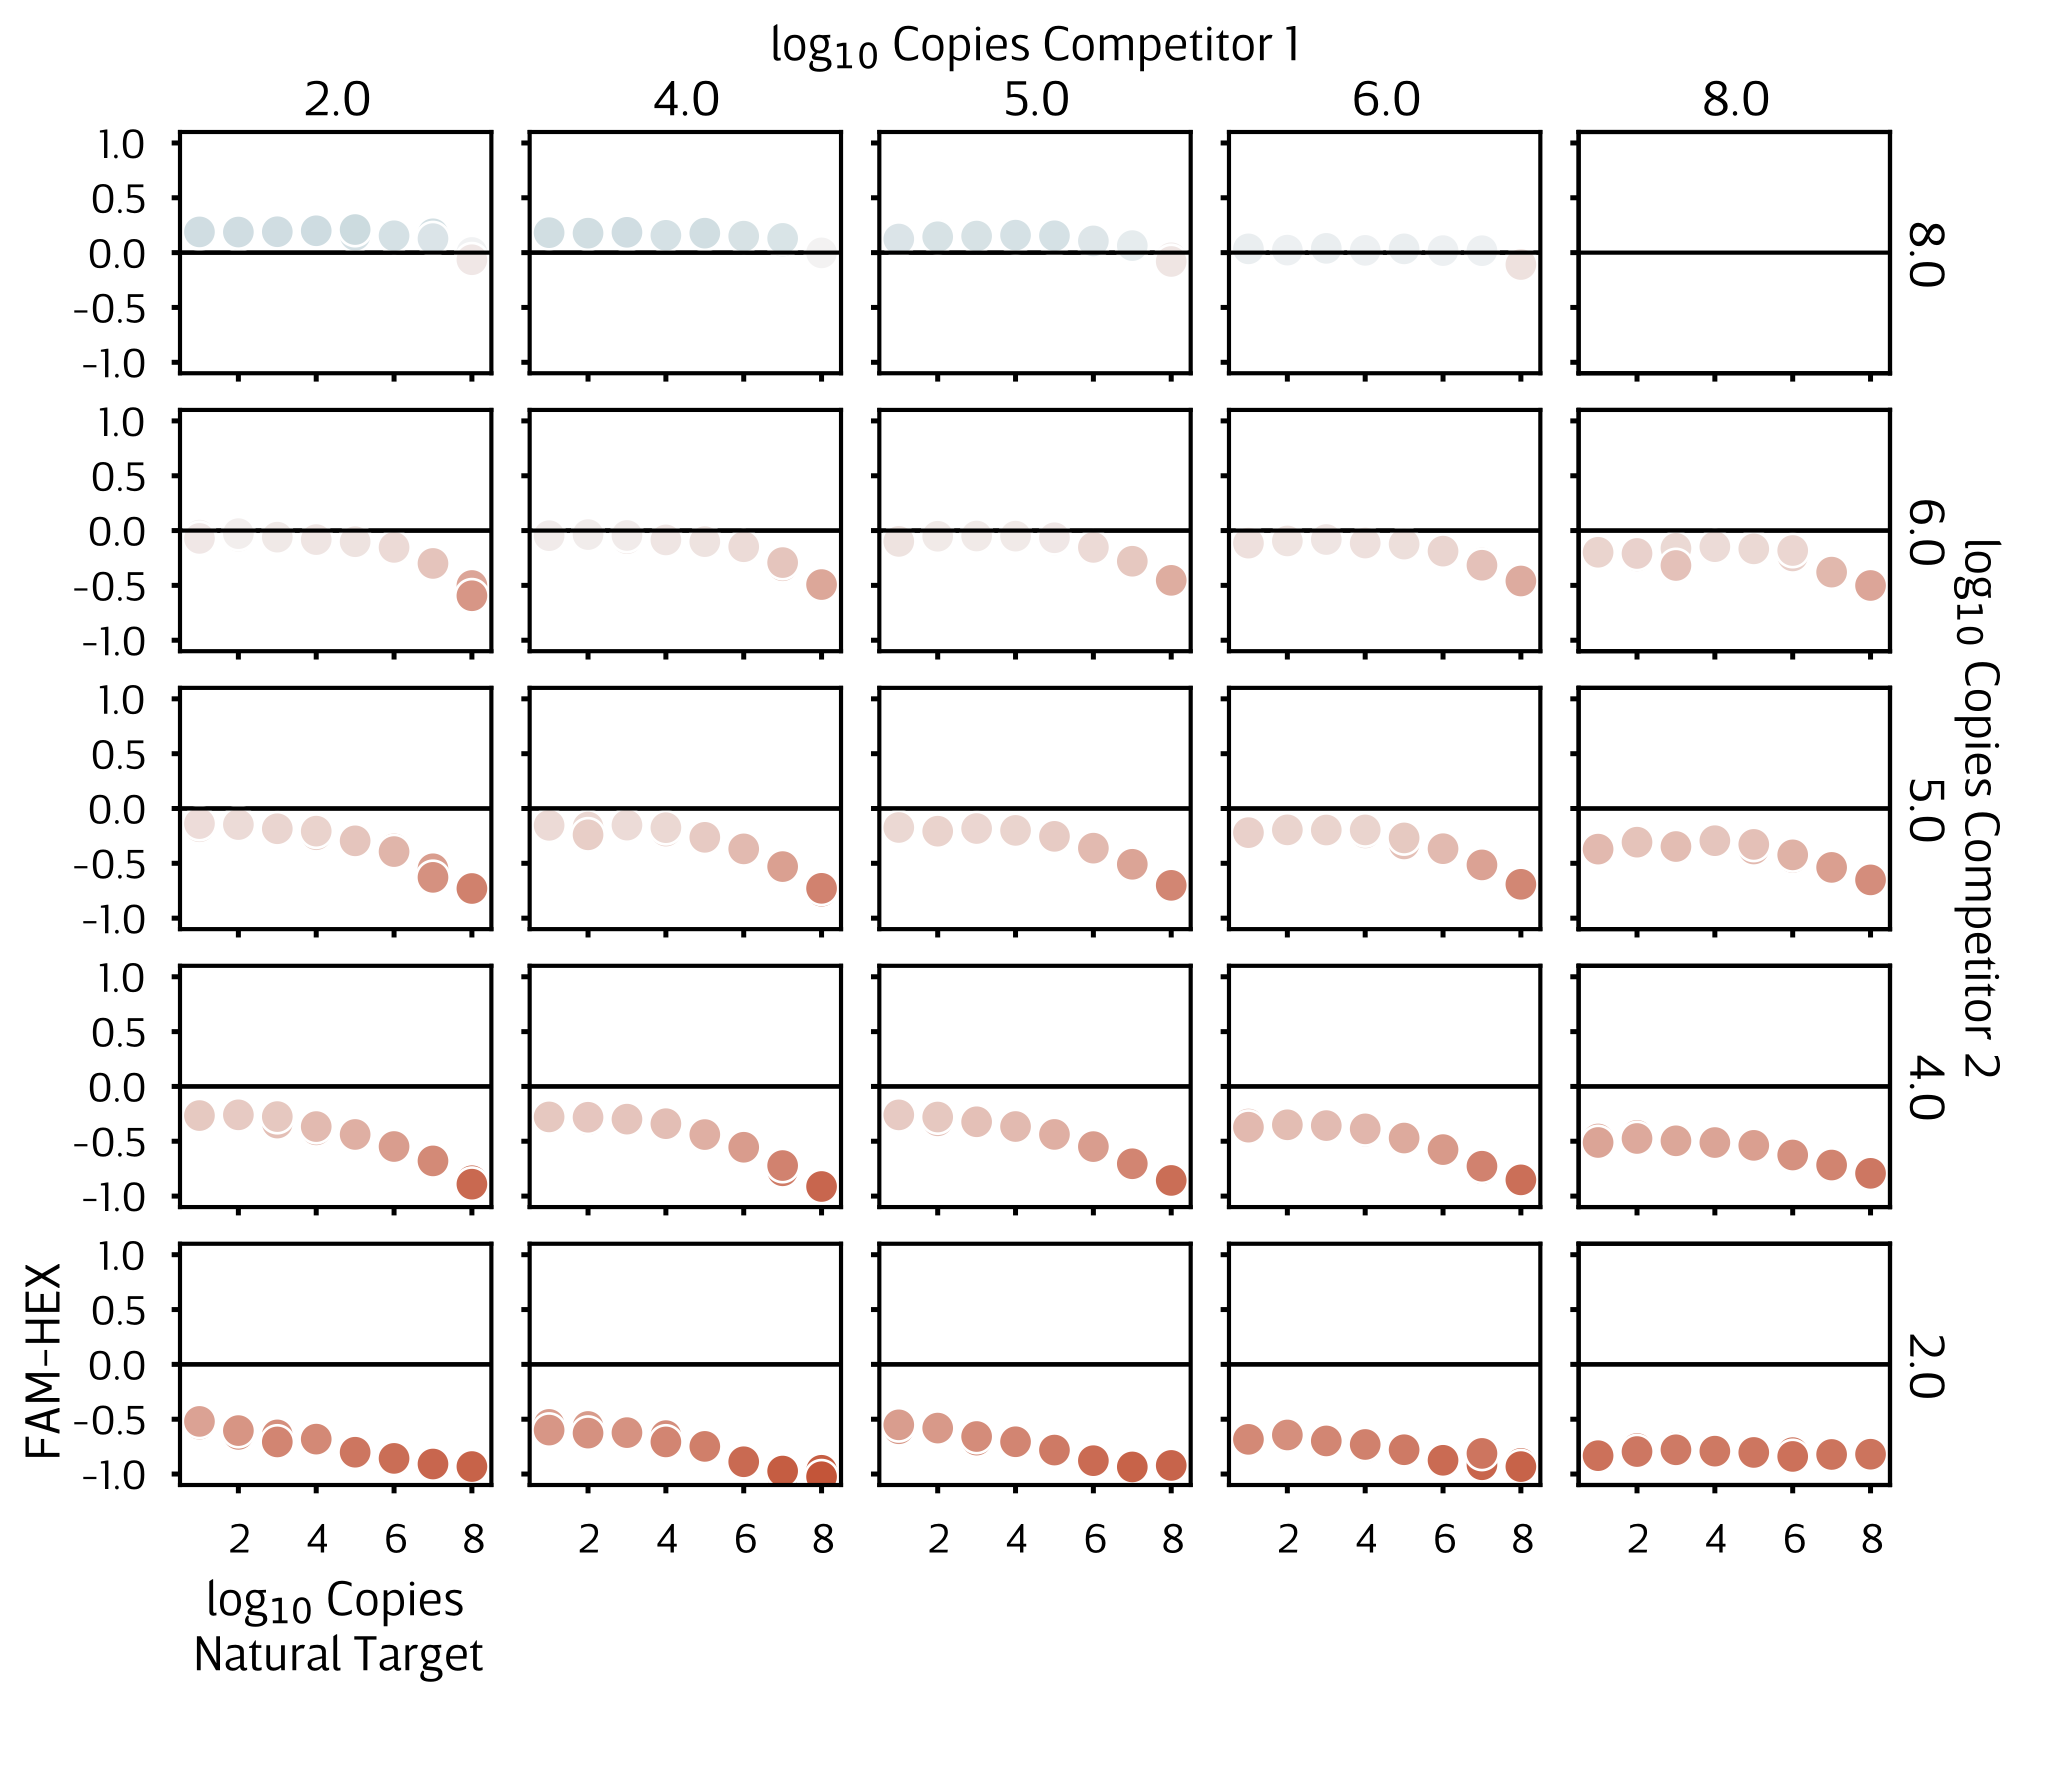

In [6]:
endpoints = JG071A.endpoints

hue = "FAM-HEX"
extent = np.max(np.abs(endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)
data = endpoints[endpoints.Reporter == "FAM"]

g = sns.relplot(
    data=endpoints[endpoints.Reporter == "FAM"],
    x="log$_{1}$$_{0}$ S036.0",
    y=hue,
    col="log$_{1}$$_{0}$ S057.0.1",
    row="log$_{1}$$_{0}$ S057.1.2",
    hue=hue,
    hue_norm=norm,
    legend=False,
    palette=palette,
    kind="scatter",
    s=spotsize,
    row_order=endpoints["log$_{1}$$_{0}$ S057.1.2"].unique()[::-1],
    facet_kws={"margin_titles": False, "despine": False},
)

g.refline(y=0, color="k", linestyle="-", linewidth=0.5)
format_sns_axes(g, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])

g.axes[-1, 0].set_xlabel(r"log$_{10}$ Copies" + "\nNatural Target")

savefig(plt.gcf(), alias="crimson_stingray")